In [1]:
import os
import random
import torch
import dgl
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from statistics import mean

c:\Users\Ankit Dash\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Metadata

In [2]:
# Constants
# Control Parameters


CONTROL_PARAMS = {
'DEFAULT_AGE_LB' : 20,
'DEFAULT_AGE_UB' : 40,

'NUM_ADULTS_PROBABILITIES' : [0, 0.65, 1],
'NUM_CHILDREN_PROBABILITIES' : [0.2, 0.45, 0.9, 1],
'NUM_PARENTS_PROBABILITIES' : [0.5, 0.65, 1],

'ADULT_AGE_RANGE' : (30, 50),

'BMI_LB' : 15,
'BMI_UB' : 28,
'BMI_RANGE' : (15, 28),

'CHILDREN_AGE_DIFF_LB' : 25,
'CHILDREN_AGE_DIFF_UB' : 28,

'PARENT_AGE_DIFF_LB' : 30,
'PARENT_AGE_DIFF_UB' : 35,

'FAMILY_PER_APARTMENT' : 20,

'APARTMENTS' : 3,
'HOMES' : 25,

'RETIREMENT_AGE' : 65,
'OFFICE_AGE' : 25,
'UNI_AGE' : 18,
'COLLEGE_AGE' : 16,
'SECONDARY_AGE' : 11,
'PRIMARY_AGE' : 5,

'EMPLOYMENT_RATE' : 0.6,
'UNI_RATE' : 0.7,
'COLLEGE_RATE' : 0.75,
'SECONDARY_RATE' : 0.9,
'PRIMARY_RATE' : 0.95,
'PRE_RATE' : 0.99,

'OFFICE_CAPACITY' : 75,
'SHOP_CAPACITY' : 30,

'APARTMENT_CONTACTS_SCALE' : 1,
'OFFICE_CONTACTS_SCALE' : 1.5,
'SCHOOL_CONTACTS_SCALE' : 2,
'SHOP_CONTACTS_SCALE' : 2,
'FAMILY_CONTACTS_SCALE' : 2
}

In [3]:
def pick(probabilities):
    val = random.random()
    for i, probability in enumerate(probabilities):
        if val <= probability:
            return i

In [4]:
class Person:
    count = 0
    people = []

    def __init__(self, family, age=None, bmi=None, apartment=-1, home=-1):
        self.id = Person.count
        self.age = random.randint(CONTROL_PARAMS['DEFAULT_AGE_LB'], CONTROL_PARAMS['DEFAULT_AGE_UB']) if age == None else random.randint(age[0], age[1])
        self.bmi = random.randint(CONTROL_PARAMS['BMI_LB'], CONTROL_PARAMS['BMI_UB']) if bmi == None else random.randint(bmi[0], bmi[1])
        self.apartment = apartment
        self.home = home
        self.family = family
        self.office = -1
        self.school = -1

        Person.count = Person.count + 1

    def __repr__(self):
        return str({
            'id': self.id,
            'age': self.age,
            'bmi': self.bmi,
            'apartment': self.apartment,
            'home': self.home,
            'family': self.family,
            'office': self.office,
            'school': self.school
        })

In [5]:
class Family:
    # assuming a city population
    # imagine families to be based around 1 or 2 adults of age [30, 60]
    # having a bmi between [15, 28]
    # having chance c of having children 1, 2 or 3 children of age [1, m - [25-30]]
    # where m in the age of the younger adult
    # and having chance p of living with 0, 1 or 2 of their parents
    # whose age would be in range [M + [20-25], 85]
    count = 0

    a = CONTROL_PARAMS["NUM_ADULTS_PROBABILITIES"]
    c = CONTROL_PARAMS["NUM_CHILDREN_PROBABILITIES"]
    p = CONTROL_PARAMS["NUM_PARENTS_PROBABILITIES"]
    def __init__(self, n=None, apartment=-1, home=-1):
        self.members = []
        self.id = Family.count
        Family.count = Family.count + 1

        if n is not None:
            for _ in range(n):
                person = Person(family=self.id, apartment=apartment, home=home)
                Person.people.append(person)
                self.members.append(person.id)
    
        adults = pick(Family.a)
        children = pick(Family.c)
        parents = pick(Family.p)

        m = 100
        M = -1

        for _ in range(adults):
            person = Person(age=CONTROL_PARAMS["ADULT_AGE_RANGE"], bmi=CONTROL_PARAMS["BMI_RANGE"], family=self.id, apartment=apartment, home=home)
            Person.people.append(person)
            m = min(m, person.age)
            M = max(M, person.age)
            self.members.append(person.id)

        for _ in range(children):
            person = Person(age=(1, m - random.randint(CONTROL_PARAMS['CHILDREN_AGE_DIFF_LB'], CONTROL_PARAMS['CHILDREN_AGE_DIFF_UB'])), bmi=CONTROL_PARAMS['BMI_RANGE'], apartment=apartment, home=home, family=self.id)
            Person.people.append(person)
            self.members.append(person.id)

        for _ in range(parents):
            person = Person(age=(M + CONTROL_PARAMS['PARENT_AGE_DIFF_LB'], M + CONTROL_PARAMS['PARENT_AGE_DIFF_UB']), bmi=CONTROL_PARAMS['BMI_RANGE'], apartment=apartment, home=home, family=self.id)
            Person.people.append(person)
            self.members.append(person.id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.members)


In [6]:
class Home:
    count = 0

    def __init__(self):
        self.id = Home.count
        self.family = Family(home=self.id)
        Home.count = Home.count + 1

    def __repr__(self):
        return str(self.id) + ":" + str(self.family)


In [7]:
class Apartment:
    size = CONTROL_PARAMS["FAMILY_PER_APARTMENT"]
    count = 0
    
    def __init__(self):
        self.families = [Family(apartment=Apartment.count) for _ in range(Apartment.size)]
        self.people = set()
        for family in self.families:
            self.people.update(family.members)
        Apartment.count = Apartment.count + 1

    def __repr__(self):
        return str(self.families)

In [8]:
class Office:
    count = 0

    def __init__(self):
        self.id = Office.count
        Office.count = Office.count + 1
        self.employees = set()

    def hire(self, id):
        Person.people[id].office = self.id
        self.employees.add(id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.employees)


In [9]:
class School:
    count = 0

    def __init__(self):
        self.id = School.count
        School.count = School.count + 1
        self.students = set()

    def admit(self, id):
        Person.people[id].school = self.id
        self.students.add(id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.students)

In [10]:
class Society:
    
    def __init__(
        self,
        apartments=CONTROL_PARAMS["APARTMENTS"],
        homes=CONTROL_PARAMS["HOMES"]
    ):
        self.n_apartments = apartments
        self.apartments = [Apartment() for _ in range(apartments)]

        self.n_homes = homes
        self.homes = [Home() for _ in range(homes)]

        self.n_offices = Person.count // CONTROL_PARAMS['OFFICE_CAPACITY'] + 1
        self.offices = [Office() for _ in range(self.n_offices)]
        
        self.pre = School()
        self.primary = School()
        self.secondary = School()
        self.college = School()
        self.uni = School()
        
        for person in Person.people:
            if person.age > CONTROL_PARAMS['RETIREMENT_AGE']:
                continue
            if person.age >= CONTROL_PARAMS['OFFICE_AGE']:
                if random.random() <= CONTROL_PARAMS['EMPLOYMENT_RATE']:
                    self.offices[random.randint(1, self.n_offices) - 1].hire(person.id)
            elif person.age >= CONTROL_PARAMS['UNI_AGE']:
                if random.random() <= CONTROL_PARAMS['UNI_RATE']:
                    self.uni.admit(person.id)
            elif person.age >= CONTROL_PARAMS['COLLEGE_AGE']:
                if random.random() <= CONTROL_PARAMS['COLLEGE_RATE']:
                    self.college.admit(person.id)
            elif person.age >= CONTROL_PARAMS['SECONDARY_AGE']:
                if random.random() <= CONTROL_PARAMS['SECONDARY_RATE']:
                    self.secondary.admit(person.id)
            elif person.age >= CONTROL_PARAMS['PRIMARY_AGE']:
                if random.random() <= CONTROL_PARAMS['PRIMARY_RATE']:
                    self.primary.admit(person.id)
            else:
                if random.random() <= CONTROL_PARAMS['PRE_RATE']:
                    self.pre.admit(person.id)

In [11]:
society = Society()

In [12]:
id = [person.id for person in Person.people]
age = [person.age for person in Person.people]
bmi = [person.bmi for person in Person.people]
apartment = [person.apartment for person in Person.people]
home = [person.home for person in Person.people]
family = [person.family for person in Person.people]
office = [person.office for person in Person.people]
school = [person.school for person in Person.people]

In [13]:
print(f"There are {Person.count} people in the society")

There are 310 people in the society


In [14]:
def hist(data):
    fig, axis = plt.subplots(figsize =(10, 5))
    axis.hist(data)
    plt.show()

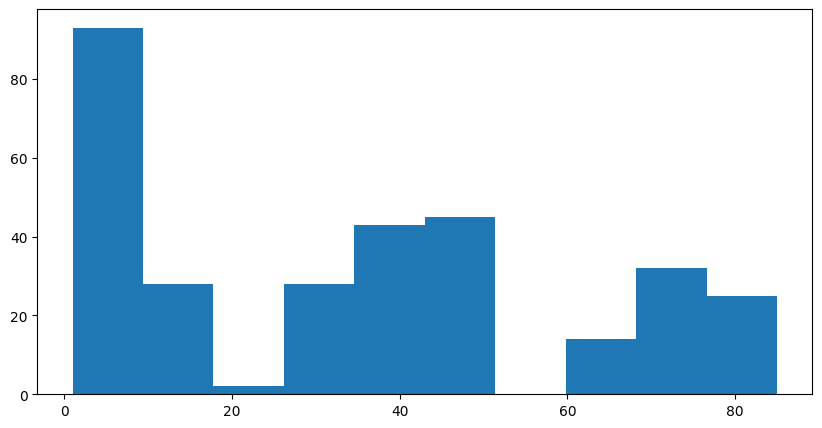

In [15]:
hist(age)

In [16]:
print(mean(age))

34.561290322580646


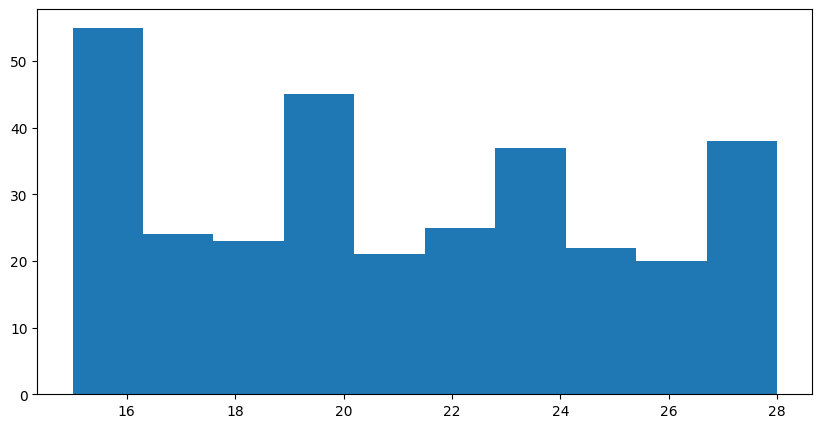

In [17]:
hist(bmi)

In [18]:
print(mean(bmi))

21.06774193548387


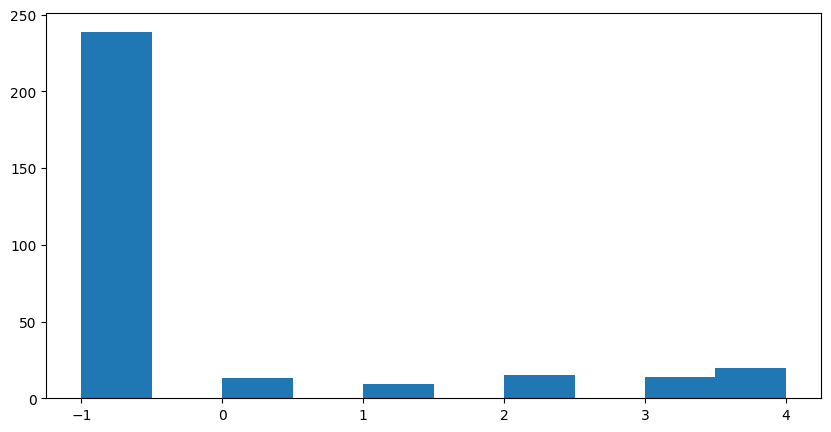

In [19]:
hist(office)

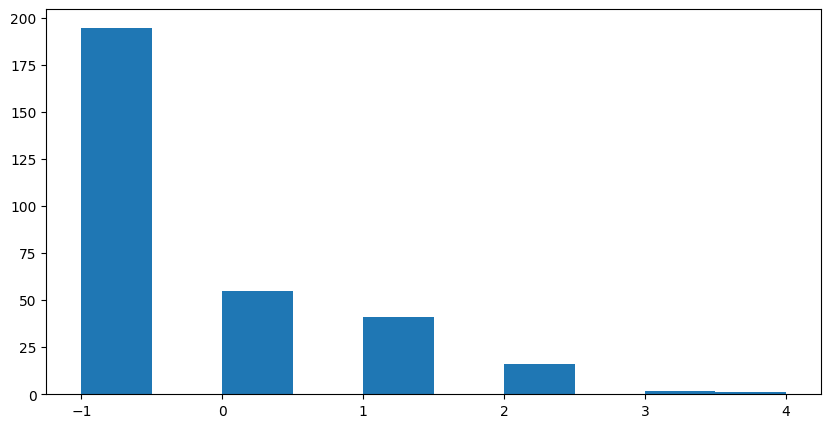

In [20]:
hist(school)

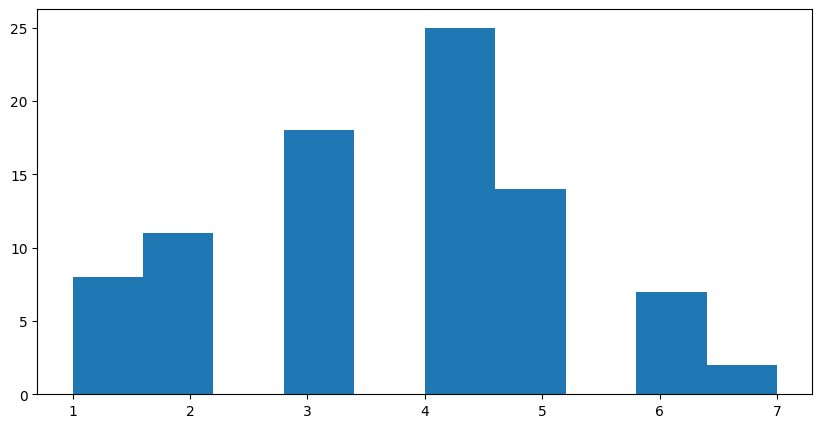

In [21]:
family_sizes = [0] * Family.count
for person in Person.people:
    family_sizes[person.family] = family_sizes[person.family] + 1

hist(family_sizes)

In [22]:
print(mean(family_sizes))

3.6470588235294117


In [23]:
data = {
    'id': id,
    'age': age,
    'bmi': bmi,
    'apartment': apartment,
    'home': home,
    'family': family,
    'office': office,
    'school': school
}
meta = pd.DataFrame(data)

## Contact Network

In [24]:
class ContactNetwork:

    def __init__(self, society):
        self.society = society
        self.timestamp = []
        self.p1 = []
        self.p2 = []
        self.time = 0

    def pick_contacts(self, pool, scale):
        n = int(len(pool) * scale)
        pool = list(pool)
        if len(pool) == 0:
            return
        for _ in range(n):
            self.p1.append(random.choice(list(pool)))
            self.p2.append(random.choice(list(pool)))
            self.timestamp.append(self.time)

    def build_contacts(self):
        for day in range(30):
            self.time = self.time + 1
            for apartment in self.society.apartments:
                self.pick_contacts(apartment.people, CONTROL_PARAMS['APARTMENT_CONTACTS_SCALE'])

            self.time = self.time + 1
            for office in self.society.offices:
                self.pick_contacts(office.employees, CONTROL_PARAMS['OFFICE_CONTACTS_SCALE'])
            for school in [self.society.pre, self.society.primary, self.society.secondary, self.society.college, self.society.uni]:
                self.pick_contacts(school.students, CONTROL_PARAMS['SCHOOL_CONTACTS_SCALE'])

            self.time = self.time + 1
            NUM_SHOPS = Person.count // CONTROL_PARAMS['SHOP_CAPACITY'] + 1
            shops = [[]] * NUM_SHOPS
            for person in Person.people:
                if random.random() <= 0.4:
                    shops[random.randint(1, NUM_SHOPS) - 1].append(person.id)
            for shop in shops:
                self.pick_contacts(shop,  CONTROL_PARAMS['SHOP_CONTACTS_SCALE'])
            for shop in shops:
                self.pick_contacts(shop,  CONTROL_PARAMS['SHOP_CONTACTS_SCALE'])


            self.time = self.time + 1
            for apartment in self.society.apartments:
                for family in apartment.families:
                    self.pick_contacts(family.members, CONTROL_PARAMS['FAMILY_CONTACTS_SCALE'])
            for home in self.society.homes:
                self.pick_contacts(home.family.members, CONTROL_PARAMS['FAMILY_CONTACTS_SCALE'])
                


        data = {
            'timestamp': self.timestamp,
            'p1': self.p1,
            'p2': self.p2,
        }
        cn = pd.DataFrame(data)

        return cn

In [25]:
builder = ContactNetwork(society)
cn = builder.build_contacts()

In [26]:
path_to_directories = ['control_params/', 'metadata/', 'contact_network/']
for directory_path in path_to_directories:
    try:
        os.makedirs(directory_path)
    except FileExistsError:
        pass

In [27]:
# Obtain the current date and time
current_time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Convert the dictionary to a json file and add a timestamp to give it an unique file name
control_params_file_path = 'control_params/control_params_' + current_time + '.json'
with open(control_params_file_path, 'w') as f:
    json.dump(CONTROL_PARAMS, f)

# Add a timestamp to the filename of the csv files
# metadata
metadata_file_path = 'metadata/metadata_' + current_time + '.csv'
meta.to_csv(metadata_file_path, header=True, index=False)
# contact network
cn_file_path = 'contact_network/contact_network_' + current_time + '.csv'
cn.to_csv(cn_file_path, header=True, index=False)

In [28]:
meta

,id,age,bmi,apartment,home,family,office,school
0,0,43,18,0,-1,0,-1,-1
1,1,40,24,0,-1,0,3,-1
2,2,7,19,0,-1,0,-1,-1
3,3,7,16,0,-1,0,-1,1
4,4,8,26,0,-1,0,-1,-1
...,...,...,...,...,...,...,...,...
305,305,10,21,-1,23,83,-1,1
306,306,81,24,-1,23,83,-1,-1
307,307,30,24,-1,24,84,-1,-1
308,308,2,22,-1,24,84,-1,0


In [29]:
cn

,timestamp,p1,p2
0,1,18,49
1,1,13,61
2,1,38,0
3,1,36,60
4,1,54,61
...,...,...,...
195449,120,307,308
195450,120,309,308
195451,120,308,309
195452,120,309,308


In [30]:
cn_array1 = cn['p1'].to_numpy()
cn_array2 = cn['p2'].to_numpy()

In [31]:
cn_array1

array([ 18,  13,  38, ..., 308, 309, 308], dtype=int64)

In [32]:
cn_array2

array([ 49,  61,   0, ..., 309, 308, 308], dtype=int64)

In [33]:
meta_array = meta.to_numpy()

In [34]:
g = dgl.graph((cn_array1, cn_array2), num_nodes=Person.count)

In [35]:
g

Graph(num_nodes=310, num_edges=195454,
      ndata_schemes={}
      edata_schemes={})

### Rudimentary Visualisation

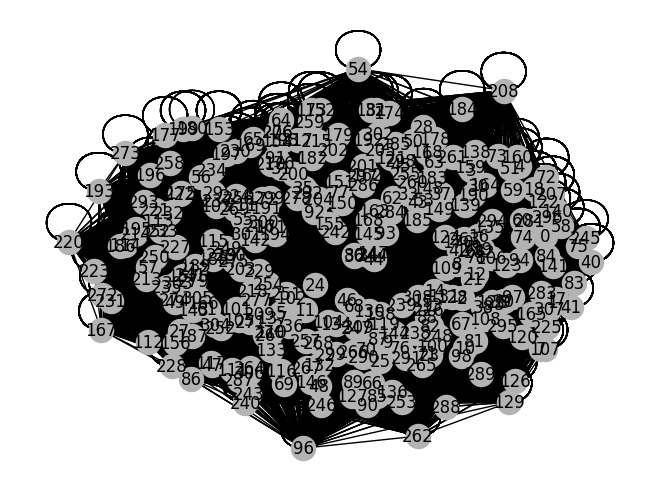

In [36]:
# A rudimentary visualisation of the entire contact network
nx_g = g.to_networkx().to_undirected()
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])